## Donald Trump

## Sentiment Analysis via NewsAPI

In [1]:
# Initial imports
import os
import pandas as pd
from datetime import datetime, timedelta
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from alpaca_trade_api.rest import REST, TimeFrame, TimeFrameUnit
import nltk as nltk
from newsapi.newsapi_client import NewsApiClient
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

import matplotlib.pyplot as plt
import dataframe_image as dfi

%matplotlib inline

In [2]:
# Set News API Key
newsapi = NewsApiClient(api_key=os.environ["NEWS_API_KEY"])

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create Alpaca Trade API client
api = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version='v2')

In [3]:
# Fetch news articles
trump_news_en = newsapi.get_everything(
    q="donald trump",
    language="en"
)

# Show the total number of news
trump_news_en["totalResults"]

15758

In [4]:
# Function to create a dataframe for news articles
def create_df(news, language):
    articles = []
    for article in news:
        try:
            title = article["title"]
            description = article["description"]
            text = article["content"]
            date = article["publishedAt"][:10]

            articles.append({
                "title": title,
                "description": description,
                "text": text,
                "date": date,
                "language": language
            })
        except AttributeError as ae:
            pass

    return pd.DataFrame(articles)

In [5]:
# Create a DataFrame with Trump news
trump_df = create_df(trump_news_en["articles"], "en") 
trump_df.head()

,title,description,text,date,language
0,Analysis: Donald Trump is getting richer again,More than 14 months after leaving office -- an...,THE POINT -- NOW ON YOUTUBE! \r\nIn each episo...,2022-04-05,en
1,Jimmy Kimmel Mocks Donald Trump’s Endorsement ...,“Trump endorsing Palin is like paste eating en...,I guess the Masked Singer money dried up and S...,2022-04-05,en
2,NY attorney general seeks to hold Donald Trump...,New York's top lawyer says Donald Trump has no...,"Image source, Getty Images\r\nNew York's top l...",2022-04-07,en
3,U.S. Sends Algerian Man Home From Guantánamo B...,The transfer had been arranged during the Obam...,"Mr. Barhoumis lawyer, Shayana Kadidal of the C...",2022-04-02,en
4,Donald Trump sues Hillary Clinton over Russian...,Donald Trump's campaign was accused of conspir...,"Image caption, Donald Trump beat Hillary Clint...",2022-03-24,en


In [6]:
# Create the sentiment scores DataFrame
def get_sentiment(score):
    """
    Calculates the sentiment based on the compound score.
    """
    result = 0  # Neutral by default
    if score >= 0.05:  # Positive
        result = 1
    elif score <= -0.05:  # Negative
        result = -1

    return result

### Sentiment Analysis

In [7]:
# Create function for sentiment score dictionaries
title_sent = {
    "title_compound": [],
    "title_pos": [],
    "title_neu": [],
    "title_neg": [],
    "title_sent": [],
}
text_sent = {
    "text_compound": [],
    "text_pos": [],
    "text_neu": [],
    "text_neg": [],
    "text_sent": [],
}

# ETH - Get sentiment for the text and the title
for index, row in trump_df.iterrows():
    try:
        # Sentiment scoring with VADER
        title_sentiment = analyzer.polarity_scores(row["title"])
        title_sent["title_compound"].append(title_sentiment["compound"])
        title_sent["title_pos"].append(title_sentiment["pos"])
        title_sent["title_neu"].append(title_sentiment["neu"])
        title_sent["title_neg"].append(title_sentiment["neg"])
        title_sent["title_sent"].append(get_sentiment(title_sentiment["compound"]))

        text_sentiment = analyzer.polarity_scores(row["text"])
        text_sent["text_compound"].append(text_sentiment["compound"])
        text_sent["text_pos"].append(text_sentiment["pos"])
        text_sent["text_neu"].append(text_sentiment["neu"])
        text_sent["text_neg"].append(text_sentiment["neg"])
        text_sent["text_sent"].append(get_sentiment(text_sentiment["compound"]))
    except AttributeError:
        pass

In [8]:
# Attaching sentiment columns to the Ethereum news dataframe
title_sentiment_df = pd.DataFrame(title_sent)
text_sentiment_df = pd.DataFrame(text_sent)
trump_df = trump_df.join(title_sentiment_df).join(text_sentiment_df)

In [9]:
# Describe Trump sentiment 
trump_df.describe()

,title_compound,title_pos,title_neu,title_neg,title_sent,text_compound,text_pos,text_neu,text_neg,text_sent
count,20.000000,20.000000,20.000000,20.00000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,-0.210675,0.067800,0.753800,0.17850,-0.450000,-0.065480,0.044250,0.850200,0.055550,-0.200000
std,0.352075,0.112159,0.206314,0.18083,0.686333,0.384019,0.052206,0.215036,0.063391,0.767772
min,-0.817600,0.000000,0.385000,0.00000,-1.000000,-0.796400,0.000000,0.000000,0.000000,-1.000000
25%,-0.447800,0.000000,0.620750,0.00000,-1.000000,-0.246500,0.000000,0.818500,0.000000,-1.000000
50%,-0.177900,0.000000,0.778000,0.18900,-1.000000,0.000000,0.032000,0.891500,0.049500,0.000000
75%,0.000000,0.171250,1.000000,0.26550,0.000000,0.000000,0.071750,0.962500,0.086500,0.000000
max,0.526700,0.362000,1.000000,0.54800,1.000000,0.718400,0.158000,1.000000,0.177000,1.000000


<AxesSubplot:title={'center':'Donald Trump News Title and Text Sentiment Comparisson'}>

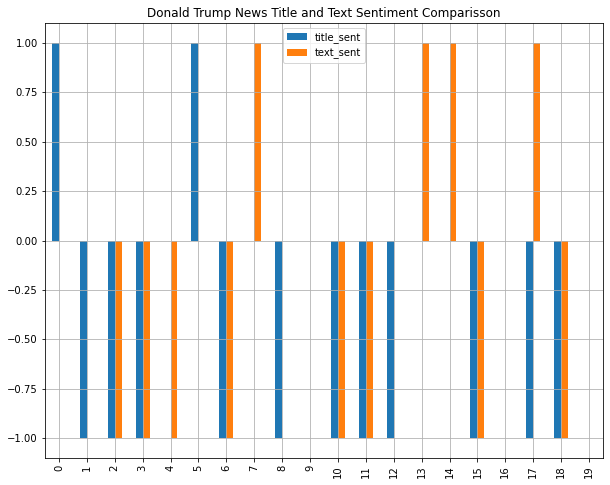

In [10]:
# Describe the Trump news sentiment
trump_df.plot(
    y=["title_sent", "text_sent"],
    kind="bar",
    title="Donald Trump News Title and Text Sentiment Comparisson",
    figsize=(10, 8),
    grid=True,
)

In [11]:
# Describe Trump dataframe 
trump_df.describe()

,title_compound,title_pos,title_neu,title_neg,title_sent,text_compound,text_pos,text_neu,text_neg,text_sent
count,20.000000,20.000000,20.000000,20.00000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,-0.210675,0.067800,0.753800,0.17850,-0.450000,-0.065480,0.044250,0.850200,0.055550,-0.200000
std,0.352075,0.112159,0.206314,0.18083,0.686333,0.384019,0.052206,0.215036,0.063391,0.767772
min,-0.817600,0.000000,0.385000,0.00000,-1.000000,-0.796400,0.000000,0.000000,0.000000,-1.000000
25%,-0.447800,0.000000,0.620750,0.00000,-1.000000,-0.246500,0.000000,0.818500,0.000000,-1.000000
50%,-0.177900,0.000000,0.778000,0.18900,-1.000000,0.000000,0.032000,0.891500,0.049500,0.000000
75%,0.000000,0.171250,1.000000,0.26550,0.000000,0.000000,0.071750,0.962500,0.086500,0.000000
max,0.526700,0.362000,1.000000,0.54800,1.000000,0.718400,0.158000,1.000000,0.177000,1.000000


## Tokenizer

In [12]:
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import reuters, stopwords
from string import punctuation
import re

In [13]:
# Instantiate the lemmatizer
lemmatizer = WordNetLemmatizer()
article = trump_df
print(article)

                                                title  \
0      Analysis: Donald Trump is getting richer again   
1   Jimmy Kimmel Mocks Donald Trump’s Endorsement ...   
2   NY attorney general seeks to hold Donald Trump...   
3   U.S. Sends Algerian Man Home From Guantánamo B...   
4   Donald Trump sues Hillary Clinton over Russian...   
5   Fred Upton, House Republican Who Supported Imp...   
6   N.Y. Attorney General Seeks to Hold Trump in C...   
7   Democratic Group Says Trump Is Breaking Campai...   
8   Text From Donald Trump Jr. Set Out Strategies ...   
9            ‘The Illegality of the Plan Was Obvious’   
10  Jan. 6 Panel Argues for Contempt Charges for F...   
11  Jan. 6 Panel Argues for Contempt Charges for F...   
12  Texts Show Ginni Thomas’s Embrace of Conspirac...   
13  Sarah Palin's House candidacy causes GOP rift ...   
14  Donald Trump's 6 January call logs show seven-...   
15  Jackson Vote Poses a Political Dilemma for Mur...   
16  How the 2022 Primaries Are 

In [14]:
# Instantiate the lemmatizer (Bitcoin)
lemmatizer = WordNetLemmatizer()
article = trump_df
print(article)

                                                title  \
0      Analysis: Donald Trump is getting richer again   
1   Jimmy Kimmel Mocks Donald Trump’s Endorsement ...   
2   NY attorney general seeks to hold Donald Trump...   
3   U.S. Sends Algerian Man Home From Guantánamo B...   
4   Donald Trump sues Hillary Clinton over Russian...   
5   Fred Upton, House Republican Who Supported Imp...   
6   N.Y. Attorney General Seeks to Hold Trump in C...   
7   Democratic Group Says Trump Is Breaking Campai...   
8   Text From Donald Trump Jr. Set Out Strategies ...   
9            ‘The Illegality of the Plan Was Obvious’   
10  Jan. 6 Panel Argues for Contempt Charges for F...   
11  Jan. 6 Panel Argues for Contempt Charges for F...   
12  Texts Show Ginni Thomas’s Embrace of Conspirac...   
13  Sarah Palin's House candidacy causes GOP rift ...   
14  Donald Trump's 6 January call logs show seven-...   
15  Jackson Vote Poses a Political Dilemma for Mur...   
16  How the 2022 Primaries Are 

In [15]:
# Create a list of stopwords
sw = set(stopwords.words('english'))

# Expand the default stopwords list if necessary
sw_addons = { "a4", "ab", "able", "about", "above", "abst", "ac", "accordance", "according", "accordingly", "across", "act", 
              "actually", "ad", "added", "adj", "ae", "af", "affected", "affecting", "after", "afterwards", "ag", "again", "against", "ah", "ain", "aj", "al", "all", "allow", "allows", "almost", 
              "alone", "along", "already", "also", "although", "always", "am", "among", "amongst", "amoungst", "amount", "an", "and", "announce", "another", "any", "anybody", "anyhow", "anymore", 
              "anyone", "anyway", "anyways", "anywhere", "ao", "ap", "apart", "apparently", "appreciate", "approximately", "ar", "are", "aren", "arent", "arise", "around", "as", "aside", "ask", 
              "asking", "at", "au", "auth", "av", "available", "aw", "away", "awfully", "ax", "ay", "az", "b", "B", "b1", "b2", "b3", "ba", "back", "bc", "bd", "be", "became", "been", "before", 
              "beforehand", "beginnings", "behind", "below", "beside", "besides", "best", "between", "beyond", "bi", "bill", "biol", "bj", "bk", "bl", "bn", "both", "bottom", "bp", "br", "brief", 
              "briefly", "bs", "bt", "bu", "but", "bx", "by", "c", "C", "c1", "c2", "c3", "ca", "call", "came", "can", "cannot", "cant", "cc", "cd", "ce", "certain", "certainly", "cf", "cg", "ch", 
              "ci", "cit", "cj", "cl", "clearly", "cm", "cn", "co", "com", "come", "comes", "con", "concerning", "consequently", "consider", "considering", "could", "couldn", "couldnt", "course", 
              "cp", "cq", "cr", "cry", "cs", "ct", "cu", "cv", "cx", "cy", "cz", "d", "D", "d2", "da", "date", "dc", "dd", "de", "definitely", "describe", "described", "despite", "detail", "df", 
              "di", "did", "didn", "dj", "dk", "dl", "do", "does", "doesn", "doing", "don", "done", "down", "downwards", "dp", "dr", "ds", "dt", "du", "due", "during", "dx", "dy", "e", "E", "e2", 
              "e3", "ea", "each", "ec", "ed", "edu", "ee", "ef", "eg", "ei", "eight", "eighty", "either", "ej", "el", "eleven", "else", "elsewhere", "em", "en", "end", "ending", "enough", "entirely", 
              "eo", "ep", "eq", "er", "es", "especially", "est", "et", "et-al", "etc", "eu", "ev", "even", "ever", "every", "everybody", "everyone", "everything", "everywhere", "ex", "exactly", 
              "example", "except", "ey", "f", "F", "f2", "fa", "far", "fc", "few", "ff", "fi", "fifteen", "fifth", "fify", "fill", "find", "fire", "five", "fix", "fj", "fl", "fn", "fo", "followed", 
              "following", "follows", "for", "former", "formerly", "forth", "forty", "found", "four", "fr", "from", "front", "fs", "ft", "fu", "full", "further", "furthermore", "fy", "g", "G", "ga", 
              "gave", "ge", "get", "gets", "getting", "gi", "give", "given", "gives", "giving", "gj", "gl", "go", "goes", "going", "gone", "got", "gotten", "gr", "greetings", "gs", "gy", "h", "H", 
              "h2", "h3", "had", "hadn", "happens", "hardly", "has", "hasn", "hasnt", "have", "haven", "having", "he", "hed", "hello", "help", "hence", "here", "hereafter", "hereby", "herein", "heres", 
              "hereupon", "hes", "hh", "hi", "hid", "hither", "hj", "ho", "hopefully", "how", "howbeit", "however", "hr", "hs", "http", "hu", "hundred", "hy", "i2", "i3", "i4", "i6", "i7", 
              "i8", "ia", "ib", "ibid", "ic", "id", "ie", "if", "ig", "ignored", "ih", "ii", "ij", "il", "im", "immediately", "in", "inasmuch", "inc", "indeed", "index", "indicate", "indicated", 
              "indicates", "information", "inner", "insofar", "instead", "interest", "into", "inward", "io", "ip", "iq", "ir", "is", "isn", "it", "itd", "its", "iv", "ix", "iy", "iz", "j", "J", 
              "jj", "jr", "js", "jt", "ju", "just", "k", "K", "ke", "keep", "keeps", "kept", "kg", "kj", "km", "ko", "l", "L", "l2", "la", "largely", "last", "lately", "later", "latter", "latterly", 
              "lb", "lc", "le", "least", "les", "less", "lest", "let", "lets", "lf", "like", "liked", "likely", "line", "little", "lj", "ll", "ln", "lo", "look", "looking", "looks", "los", "lr", 
              "ls", "lt", "ltd", "m", "M", "m2", "ma", "made", "mainly", "make", "makes", "many", "may", "maybe", "me", "meantime", "meanwhile", "merely", "mg", "might", "mightn", "mill", "million", 
              "mine", "miss", "ml", "mn", "mo", "more", "moreover", "most", "mostly", "move", "mr", "mrs", "ms", "mt", "mu", "much", "mug", "must", "mustn", "my", "n", "N", "n2", "na", "name", 
              "namely", "nay", "nc", "nd", "ne", "near", "nearly", "necessarily", "neither", "nevertheless", "new", "next", "ng", "ni", "nine", "ninety", "nj", "nl", "nn", "no", "nobody", 
              "non", "none", "nonetheless", "noone", "nor", "normally", "nos", "not", "noted", "novel", "now", "nowhere", "nr", "ns", "nt", "ny", "o", "O", "oa", "ob", "obtain", "obtained", 
              "obviously", "oc", "od", "of", "off", "often", "og", "oh", "oi", "oj", "ok", "okay", "ol", "old", "om", "omitted", "on", "once", "one", "ones", "only", "onto", "oo", "op", "oq", 
              "or", "ord", "os", "ot", "otherwise", "ou", "ought", "our", "out", "outside", "over", "overall", "ow", "owing", "own", "ox", "oz", "p", "P", "p1", "p2", "p3", "page", "pagecount", 
              "pages", "par", "part", "particular", "particularly", "pas", "past", "pc", "pd", "pe", "per", "perhaps", "pf", "ph", "pi", "pj", "pk", "pl", "placed", "please", "plus", "pm", "pn", 
              "po", "poorly", "pp", "pq", "pr", "predominantly", "presumably", "previously", "primarily", "probably", "promptly", "proud", "provides", "ps", "pt", "pu", "put", "py", "q", "Q", "qj", 
              "qu", "que", "quickly", "quite", "qv", "r", "R", "r2", "ra", "ran", "rather", "rc", "rd", "re", "readily", "really", "reasonably", "recent", "recently", "ref", "refs", "regarding", 
              "regardless", "regards", "related", "relatively", "research-articl", "respectively", "resulted", "resulting", "results", "rf", "rh", "ri", "right", "rj", "rl", "rm", "rn", "ro", 
              "rq", "rr", "rs", "rt", "ru", "run", "rv", "ry", "s", "S", "s2", "sa", "said", "saw", "say", "saying", "says", "sc", "sd", "se", "sec", "second", "secondly", "section", "seem", 
              "seemed", "seeming", "seems", "seen", "sent", "seven", "several", "sf", "shall", "shan", "shed", "shes", "show", "showed", "shown", "showns", "shows", "si", "side", "since", "sincere", 
              "six", "sixty", "sj", "sl", "slightly", "sm", "sn", "so", "some", "somehow", "somethan", "sometime", "sometimes", "somewhat", "somewhere", "soon", "sorry", "sp", "specifically", 
              "specified", "specify", "specifying", "sq", "sr", "ss", "st", "still", "stop", "strongly", "sub", "substantially", "successfully", "such", "sufficiently", "suggest", "sup", "sure", 
              "sy", "sz", "t", "T", "t1", "t2", "t3", "take", "taken", "taking", "tb", "tc", "td", "te", "tell", "ten", "tends", "tf", "th", "than", "thank", "thanks", "thanx", "that", "thats", 
              "the", "their", "theirs", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "thered", "therefore", "therein", "thereof", "therere", "theres", "thereto", 
              "thereupon", "these", "they", "theyd", "theyre", "thickv", "thin", "think", "third", "this", "thorough", "thoroughly", "those", "thou", "though", "thoughh", "thousand", "three", 
              "throug", "through", "throughout", "thru", "thus", "ti", "til", "tip", "tj", "tl", "tm", "tn", "to", "together", "too", "took", "top", "toward", "towards", "tp", "tq", "tr", 
              "tried", "tries", "truly", "try", "trying", "ts", "tt", "tv", "twelve", "twenty", "twice", "two", "tx", "u", "U", "u201d", "ue", "ui", "uj", "uk", "um", "un", "under", 
              "unfortunately", "unless", "unlike", "unlikely", "until", "unto", "uo", "up", "upon", "ups", "ur", "us", "used", "useful", "usefully", "usefulness", "using", "usually", "ut", "v", 
              "V", "va", "various", "vd", "ve", "very", "via", "viz", "vj", "vo", "vol", "vols", "volumtype", "vq", "vs", "vt", "vu", "w", "W", "wa", "was", "wasn", "wasnt", "way", "we", "wed", 
              "welcome", "well", "well-b", "went", "were", "weren", "werent", "what", "whatever", "whats", "when", "whence", "whenever", "where", "whereafter", "whereas", "whereby", "wherein", 
              "wheres", "whereupon", "wherever", "whether", "which", "while", "whim", "whither", "who", "whod", "whoever", "whole", "whom", "whomever", "whos", "whose", "why", "wi", "widely", 
              "with", "within", "without", "wo", "won", "wonder", "wont", "would", "wouldn", "wouldnt", "www", "x", "X", "x1", "x2", "x3", "xf", "xi", "xj", "xk", "xl", "xn", "xo", "xs", "xt", 
              "xv", "xx", "y", "Y", "y2", "yes", "yet", "yj", "yl", "you", "youd", "your", "youre", "yours", "yr", "ys", "yt", "z", "Z", "zero", "zi", "zz"}
stop = set(list(sw)+list(sw_addons))

In [16]:
# Define function
def tokenizer(text):
    sw = set(stopwords.words('english'))
    regex = re.compile("[^a-zA-Z ]")
    re_clean = regex.sub('', article)
    words = word_tokenize(re_clean)
    lem = [lemmatizer.lemmatize(word) for word in words]
    output = [word.lower() for word in lem if word.lower() not in sw]
    return tokens

In [17]:
# Complete the tokenizer function
def tokenizer(text):
    """Tokenizes text."""
    ## Define and apply the regex parameters
    regex = re.compile("[^a-zA-Z ]")
    re_clean = regex.sub('', text)
    
    # Create a tokenized list of the words
    words = word_tokenize(text)
    
    # Convert the words to lowercase
    words = list(filter(lambda w: w.lower(), words))
    
    # Remove the punctuation from text
    words = list(filter(lambda t: t not in punctuation, words))
    
    # Remove the stop words
    words = list(filter(lambda t: t.lower() not in stop, words))
    
    # Lemmatize words into root words
    tokens = [lemmatizer.lemmatize(word) for word in words]

    return tokens

In [18]:
# Create a new tokens column for Bitcoin
trump_df["tokens"] = trump_df.text.apply(tokenizer)
trump_df.head()

,title,description,text,date,language,title_compound,title_pos,title_neu,title_neg,title_sent,text_compound,text_pos,text_neu,text_neg,text_sent,tokens
0,Analysis: Donald Trump is getting richer again,More than 14 months after leaving office -- an...,THE POINT -- NOW ON YOUTUBE! \r\nIn each episo...,2022-04-05,en,0.5267,0.362,0.638,0.000,1,0.0000,0.000,1.000,0.000,0,"[POINT, --, YOUTUBE, episode, weekly, YouTube,..."
1,Jimmy Kimmel Mocks Donald Trump’s Endorsement ...,“Trump endorsing Palin is like paste eating en...,I guess the Masked Singer money dried up and S...,2022-04-05,en,-0.1779,0.187,0.569,0.244,-1,0.0000,0.068,0.865,0.068,0,"[guess, Masked, Singer, money, dried, Sarah, r..."
2,NY attorney general seeks to hold Donald Trump...,New York's top lawyer says Donald Trump has no...,"Image source, Getty Images\r\nNew York's top l...",2022-04-07,en,-0.5859,0.000,0.743,0.257,-1,-0.7430,0.043,0.788,0.169,-1,"[Image, source, Getty, Images, York, 's, lawye..."
3,U.S. Sends Algerian Man Home From Guantánamo B...,The transfer had been arranged during the Obam...,"Mr. Barhoumis lawyer, Shayana Kadidal of the C...",2022-04-02,en,-0.3182,0.000,0.813,0.187,-1,-0.5994,0.063,0.767,0.170,-1,"[Mr., Barhoumis, lawyer, Shayana, Kadidal, Cen..."
4,Donald Trump sues Hillary Clinton over Russian...,Donald Trump's campaign was accused of conspir...,"Image caption, Donald Trump beat Hillary Clint...",2022-03-24,en,0.0000,0.000,1.000,0.000,0,-0.1779,0.000,0.950,0.050,-1,"[Image, caption, Donald, Trump, beat, Hillary,..."


In [19]:
# Create a new tokens column for Ethereum
trump_df["tokens"] = trump_df.text.apply(tokenizer)
trump_df.head()

,title,description,text,date,language,title_compound,title_pos,title_neu,title_neg,title_sent,text_compound,text_pos,text_neu,text_neg,text_sent,tokens
0,Analysis: Donald Trump is getting richer again,More than 14 months after leaving office -- an...,THE POINT -- NOW ON YOUTUBE! \r\nIn each episo...,2022-04-05,en,0.5267,0.362,0.638,0.000,1,0.0000,0.000,1.000,0.000,0,"[POINT, --, YOUTUBE, episode, weekly, YouTube,..."
1,Jimmy Kimmel Mocks Donald Trump’s Endorsement ...,“Trump endorsing Palin is like paste eating en...,I guess the Masked Singer money dried up and S...,2022-04-05,en,-0.1779,0.187,0.569,0.244,-1,0.0000,0.068,0.865,0.068,0,"[guess, Masked, Singer, money, dried, Sarah, r..."
2,NY attorney general seeks to hold Donald Trump...,New York's top lawyer says Donald Trump has no...,"Image source, Getty Images\r\nNew York's top l...",2022-04-07,en,-0.5859,0.000,0.743,0.257,-1,-0.7430,0.043,0.788,0.169,-1,"[Image, source, Getty, Images, York, 's, lawye..."
3,U.S. Sends Algerian Man Home From Guantánamo B...,The transfer had been arranged during the Obam...,"Mr. Barhoumis lawyer, Shayana Kadidal of the C...",2022-04-02,en,-0.3182,0.000,0.813,0.187,-1,-0.5994,0.063,0.767,0.170,-1,"[Mr., Barhoumis, lawyer, Shayana, Kadidal, Cen..."
4,Donald Trump sues Hillary Clinton over Russian...,Donald Trump's campaign was accused of conspir...,"Image caption, Donald Trump beat Hillary Clint...",2022-03-24,en,0.0000,0.000,1.000,0.000,0,-0.1779,0.000,0.950,0.050,-1,"[Image, caption, Donald, Trump, beat, Hillary,..."


# NGrams and Frequency Analysis

In [20]:
from collections import Counter
from nltk import ngrams

In [21]:
# Generate the N-grams where N=2
N = 2
grams = ngrams(tokenizer(trump_df.text.str.cat()), N)
Counter(grams).most_common(20)

[(('Donald', 'Trump'), 8),
 (('Hillary', 'Clinton'), 3),
 (('President', 'Donald'), 3),
 (('char', 'statement'), 3),
 (('JIMMY', 'KIMMEL'), 2),
 (('char', 'Image'), 2),
 (('Image', 'source'), 2),
 (('source', 'Getty'), 2),
 (('Getty', 'Images'), 2),
 (('judge', 'hold'), 2),
 (('hold', 'Donald'), 2),
 (('Trump', 'contempt'), 2),
 (('failing', 'turn'), 2),
 (('Mr.', 'Trump'), 2),
 (('Mr.', 'Trumps'), 2),
 (('statement', 'emailed'), 2),
 (('emailed', 'Sunday'), 2),
 (('Sunday', 'night'), 2),
 (('night', 'Mr.'), 2),
 (('Mr.', 'Navarro'), 2)]

In [22]:
# Function token_count generates the top 10 words for a given coin
def token_count(tokens, N=3):
    """Returns the top N tokens from the frequency count"""
    return Counter(tokens).most_common(N)

In [23]:
# Use token_count to get the top 10 words for Trump
trump_tokens = tokenizer(trump_df.text.str.cat())
token_count(trump_tokens, N = 10)

[('char', 18),
 ('Trump', 14),
 ('Donald', 9),
 ('Mr.', 8),
 ('President', 5),
 ('House', 4),
 ('Image', 3),
 ('lawyer', 3),
 ('Hillary', 3),
 ('Clinton', 3)]

---

### Word Clouds


In [24]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [20.0, 10.0]

Text(0.5, 1.0, 'Donald Trump Word Cloud')

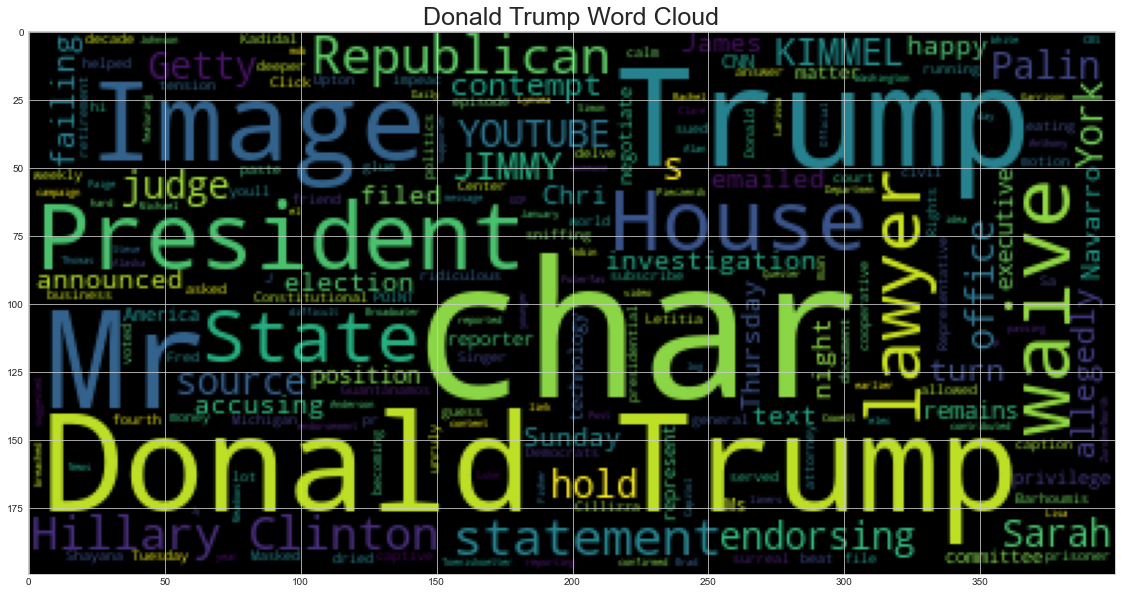

In [25]:
# Generate the Bitcoin word cloud
word_cloud = WordCloud().generate(' '.join(trump_tokens))
plt.imshow(word_cloud)
plt.title("Donald Trump Word Cloud", fontdict={'fontsize':25})

## Named Entity Recognition

In [26]:
import spacy
from spacy import displacy

In [27]:
# Load the spaCy model
nlp = spacy.load('en_core_web_sm')

In [28]:
# Concatenate all of the Bitcoin text together
trump_NER = trump_df["text"].str.cat()

In [29]:
# Run the NER processor on all of the text
doc = nlp(trump_NER)

# Add a title to the document
doc.user_data["title"]="Donald Trump NER"

In [30]:
# Render the visualization
displacy.render(doc, style='ent')

In [31]:
# List all Entities
for i in doc.ents:
    print(i.text, i.label_)

weekly DATE
YouTube ORG
Chris Cillizza PERSON
Sarah PERSON
Trump ORG
Palin GPE
Getty Images ORG
New York's GPE
Donald Trump PERSON
Shayana Kadidal PERSON
the Center for Constitutional Rights ORG
one CARDINAL
Guantánamos GPE
Donald Trump PERSON
Hillary Clinton PERSON
2016 DATE
US GPE
Donald Trump PERSON
Hillary Clinton PERSON
Democrats NORP
Fred Upton PERSON
Michigan GPE
Republican NORP
House ORG
more than three decades DATE
Tuesday DATE
fourth ORDINAL
House ORG
Republican NORP
New York State GPE
Letitia James PERSON
Thursday DATE
Donald J. Trump PERSON
Trump PERSON
Trumps PERSON
Alan Futerfas PERSON
Donald Trump Jr. PERSON
Broadwater PERSON
Daily DATE
Lisa Tobin PERSON
Rachel Quester PERSON
Lynsea Garrison PERSON
Clare Toeniskoetter PERSON
Paige Cowett PERSON
Michael Simon Johnson PERSON
Brad Fisher PERSON
Larissa Anderson PERSON
Chri ORG
Sunday DATE
night TIME
Navarro PERSON
Trump PERSON
chars]In PERSON
Sunday DATE
night TIME
Navarro PERSON
Trump PERSON
one CARDINAL
The Washington Pos